# Deep Learning for MRI reconstruction: about hallucinations and instabilities

In this tutorial, we will investigate the use of **deep learning models for the reconstruction of Magnetic Resonance Imaging (MRI) data**. You will reproduce experiments from:

 * *Gottschling, N. M., Antun, V., Hansen, A. C., & Adcock, B. (2025). The troublesome kernel: On hallucinations, no free lunches, and the accuracy-stability tradeoff in inverse problems. SIAM Review, 67(1), 73-104.* [[arxiv]](https://arxiv.org/pdf/2001.01258),


that uses machine learning models introduced in:
 
 * *Zhu, B., Liu, J. Z., Cauley, S. F., Rosen, B. R., & Rosen, M. S. (2018). Image reconstruction by domain-transform manifold learning. Nature, 555(7697), 487-492.*,

 *  *Schlemper, J., Caballero, J., Hajnal, J. V., Price, A., & Rueckert, D. (2017, May). A deep cascade of convolutional neural networks for MR image reconstruction. In International conference on information processing in medical imaging (pp. 647-658). Cham: Springer International Publishing.* [[arxiv]](https://arxiv.org/pdf/1703.00555).

The data used for this tutorial was modified from the [NYU fastMRI dataset](https://fastmri.med.nyu.edu/):

 * *Knoll et al. (2020). fastMRI: A Publicly Available Raw k-Space and DICOM Dataset of Knee Images for Accelerated MR Image Reconstruction Using Machine Learning. Radiology: Artificial Intelligence. doi: 10.1148/ryai.2020190007.* [[arxiv]](https://arxiv.org/pdf/1811.08839)




#### Structure of the repo

The code for running this tutorial is available at https://github.com/Romain3Ch216/DL4IA/tree/main/docs/tutorials/mri_restoration. We suggest to fork the [DL4IA](https://github.com/Romain3Ch216/DL4IA) repo and clone your fork:
```
git clone git@github.com:<your-username>/DL4IA.git

```

The repo contains the following files, with code **to be completed**.
```
mri_restoration
├── configs
    ├── automap.yaml
    ├── exp_deepnetmri.yaml
├── models
    ├── automap.py
    ├── deepnet_mri.py
├── dataset.py
├── mri_restoration.ipynb
├── train.py
├── utils.py
```

#### MRI reconstruction: motivation and challenges

As stated by Knoll et al. (2020), "the excellent soft tissue contrast and flexibility of magnetic resonance imaging (MRI) makes it a very powerful diagnostic tool for a wide range of disorders [...]. However, the **long acquisition time** in MRI, which can easily exceed 30 minutes, leads to low patient throughput, **problems with patient comfort and compliance, artifacts from patient motion, and high exam costs**.".

"**MR imaging is an indirect process, whereby cross-sectional images of the subject’s anatomy are produced from frequency and phase measurements** instead of direct, spatially-resolved measurements." Hence, the measurement lies in the Fourier-space, called the k-space in medical imaging, and the image is computed through the inverse Fourier transform.

Let's plot the MRI raw k-space data. k-space data is complex: we therefore plot the module on one side and the phase on the other. Low-frequency components of the signal are located at the center of k-space, and high-frequency components at the periphery.

In [1]:
import os
import numpy as np
from matplotlib import pyplot as plt

In [2]:
data_folder = '/Users/mafaldafrere/Documents/Cours/IODAA/COMPUTER_VISION/DL4IA/docs/tutorials/mri_restoration/data/brain_mri_singlecoil_slice_1/' 
file_name = 'file_brain_AXT1POST_203_6000812.npy'
kspace = np.load(os.path.join(data_folder, file_name))

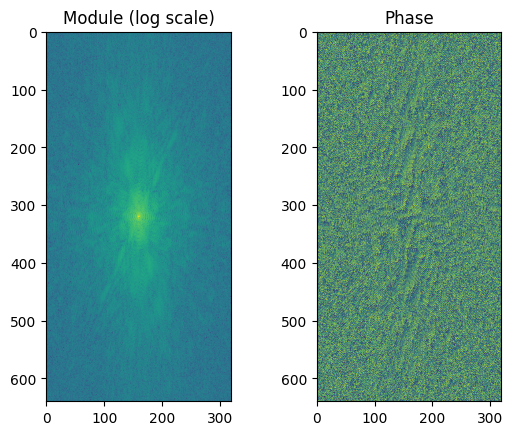

In [3]:
fig, ax = plt.subplots(1, 2)
ax[0].imshow(np.log(np.abs(kspace) + 1e-9))
ax[0].set_title('Module (log scale)')
ax[1].imshow(np.angle(kspace))
ax[1].set_title('Phase')
plt.show()

Transform and show the data in image space.

In [4]:
import numpy as np
image = np.fft.ifft2(kspace)

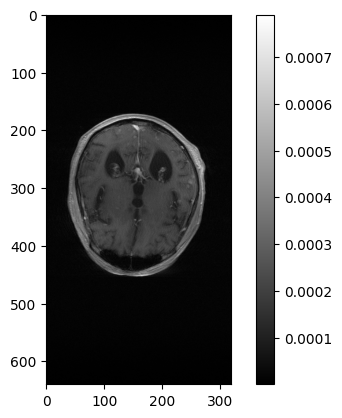

In [5]:
fig, ax = plt.subplots()
plt.imshow(np.abs(image), cmap='gray')
plt.colorbar()
plt.show()

So, data is acquired by sampling the k-space up to a maximum frequency. The higher the maximum frequency, the longer the acquisition time. In order to decrease the acquisition time, Knoll et al. (2020) explain that "fewer samples can be captured by sampling up to a lower maximum frequency, however this produces images of lower spatial resolution. **An alternative undersampling approach involves omitting
some number of k-space samples within a given maximum frequency range, which then results in aliasing artifacts.**"

In the following, **we will simulate m-dimensional undersampled acquisition from N-dimensional fully-sampled acquisition**. The MRI acceleration methods result in columns ommited from the k-space data, with most of available data for low frequencies. We will perform 8-fold acceleration (*i.e.* the acceleration factor equals 8) and follow the procedure of (Knoll et al. 2020): the fully-sampled central region includes 4% of all k-space lines for 8-fold acceleration.

Update the function `kspace_mask` in `dataset.py` and show a random undersampling mask.

In [6]:
np.random.seed(3)
from dataset import kspace_mask

In [7]:
mask = kspace_mask(kspace.shape, acceleration_factor=8)

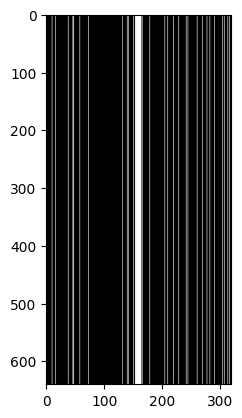

In [8]:
fig = plt.figure()
plt.imshow(
    mask.unsqueeze(0).repeat(kspace.shape[0], 1),
    cmap='gray'
)
plt.show()

Use the mask to simulate an under-sampled acquisition. Show the zero-filled reconstruction (i.e. the reconstructed image from the under-sampled k-space measurement filled with zeros where there is no data).

In [16]:
import torch 
obs_kspace = np.zeros_like(kspace)
obs_kspace[:,mask]=kspace[:,mask]
obs_image = np.abs(np.fft.ifft2(obs_kspace))

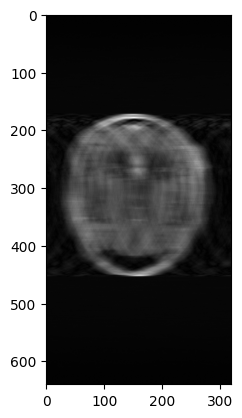

In [17]:
fig = plt.figure()
plt.imshow(obs_image, cmap='gray')
plt.show()

Undersampling leads to an **information loss**, framing the problem of MRI reconstruction as an **ill-posed inverse problem**:
$$\mbox{given measurements $y = Ax + e$, recover $x$},$$
where $x \in \mathbb{C}^N$ is the fully-sampled MRI, $y \in \mathbb{C}^m$ is the under-sampled k-space observation, $A$ is the sampling operator (the Fourier transform and the undersampling), and $e$ is a measurement noise. The problem is ill-posed (it does not admit a unique solution) because the **kernel $\mathcal{N}(A)$ of the sampling operator is nontrivial** (as $m < N$):
$$\mathcal{N}(A) := \{x \vert Ax = 0\} \neq \{0\}$$

In this tutorial, we are interested in methods that learn a reconstruction map $\hat{\Psi} : \mathbb{C}^m \longrightarrow \mathbb{C}^N$ from a training set $\mathcal{T} = \{(y_i, x_i)\}_{i=1}^K$ where $y_i = Ax_i + e_i$.

#### MRI reconstruction: DL models can hallucinate due to detail transfer

We are going to look at the first result of (Gottschling et al., 2025).

**[Main result 2.1]** Let $x \in \mathbb{C}^N$ and $x_{det}$ be a detail that either belongs to $\mathcal{N}(A)$ or lies close to it (i.e., $\|Ax_{det}\| \ll 1$ for some norm $\|\cdot\|$). Then, any map $\Psi$ that recovers the detail image $x + x_{det}$ will hallucinate by incorrectly transferring this detail when reconstructing the detail-free image $x$, i.e. $\Psi(Ax + e) \approx x + x_{det}$.

Besides, Gottschling et al. emphasize on the fact that **this is not a statement about overfitting**. Their result applies for all mappings, including neural networks that do not overfit.

In the Figure 2 of their paper, they illustrate this result on a toy example. In this tutorial, we are going to illustrate this transfer detail on a toy example as well, with a neural network trained on a single data point. The data is available in the `exp_fig_2` folder:

* `file_brain_AXT1POST_203_6000812.npy` is a MRI sample, that we will denote as $x_1$,
  
* `file_brain_AXT1POST_203_6000812_apt.npy` is the same MRI sample corrupted with a small detail, that we will denote as $x_2 = x_1 + x_{det}$.

Show the measurements and the targets, and compute $\|Ax_{det}\|_2$.

In [11]:
import torch
import yaml
from dataset import fastMriData

In [12]:
cfg_file = 'configs/automap.yaml'
exp_fig2_data_folder = '../exp_fig_2'

with open(cfg_file, 'r') as file:
    cfg = yaml.safe_load(file)

dataset = fastMriData(exp_fig2_data_folder, mask=mask, mean=cfg['data_mean'], std=cfg['data_std'])

In [13]:
image, kspace, target_image, target_kspace = dataset.__getitem__(0)
image_det, kspace_det, target_image_det, target_kspace_det = dataset.__getitem__(1)

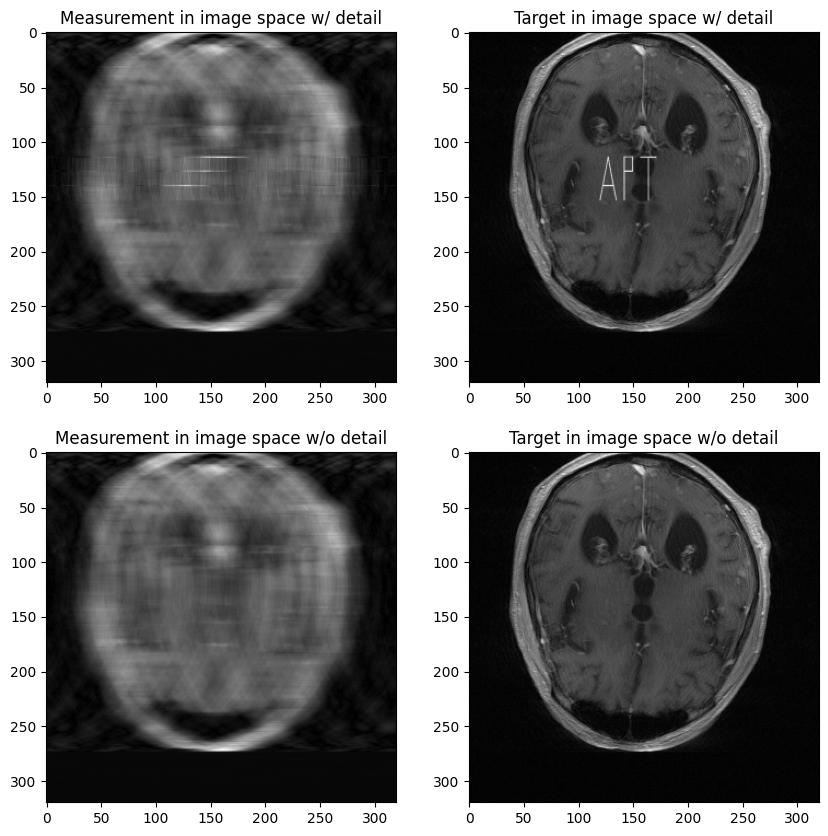

In [14]:
fig, ax = plt.subplots(2, 2, figsize=(10,10))
ax[1, 0].imshow(image, cmap='gray')
ax[1, 1].imshow(target_image, cmap='gray')
ax[0, 0].imshow(image_det, cmap='gray')
ax[0, 1].imshow(target_image_det, cmap='gray')
ax[1, 0].set_title('Measurement in image space w/o detail')
ax[1, 1].set_title('Target in image space w/o detail')
ax[0, 0].set_title('Measurement in image space w/ detail')
ax[0, 1].set_title('Target in image space w/ detail')
plt.show()

In `models/automap.py`, define the AUTOMAP model introduced in (Zhu et al., 2018), and illustrated by (Gottschling, 2022). AUTOMAP takes as input the observed k-space data, and outputs the target data in image space. Instead of a hidden dimension of 25000 at the second layer, use a dimension of 64.

<center>
    <img src="figures/automap.png" width=800>
</center>
<center>
    Source: <a href="https://www.repository.cam.ac.uk/items/f24dce55-9d82-4515-8124-ede37e935657">(Gottschling, 2022)</a>
</center>


Train the Automap model to reconstruct $x_2$ with the `train.py` script, and show its reconstruction of the observations with and without the detail.

In [15]:
from models.automap import Automap

In [16]:
K = cfg['kspace_shape'][0]
m = cfg['kspace_shape'][0] * (cfg['kspace_shape'][1] // cfg['acceleration_factor'] - 1)
model_cfg = cfg['model']
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = ...

<All keys matched successfully>

In [ ]:
# Prédiction de image (*.npy) et image_det (*_apt.npy)


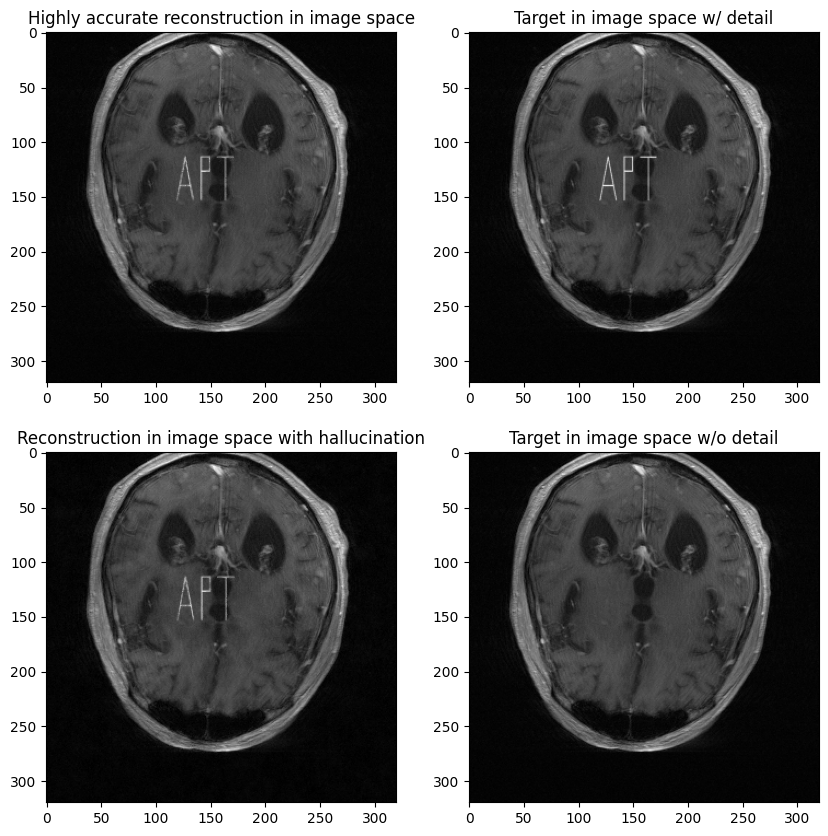

In [ ]:
min_value = target_image.min()
max_value = target_image.max()

fig, ax = plt.subplots(2, 2, figsize=(10,10))
ax[0, 0].imshow(rec_det.squeeze(0).cpu(), cmap='gray', vmin=min_value, vmax=max_value)
ax[0, 0].set_title('Highly accurate reconstruction in image space')

ax[0, 1].imshow(target_image_det, cmap='gray', vmin=min_value, vmax=max_value)
ax[0, 1].set_title('Target in image space w/ detail')

ax[1, 0].imshow(rec.squeeze(0).cpu(), cmap='gray', vmin=min_value, vmax=max_value)
ax[1, 0].set_title('Reconstruction in image space with hallucination')

ax[1, 1].imshow(target_image, cmap='gray', vmin=min_value, vmax=max_value)
ax[1, 1].set_title('Target in image space w/o detail')
plt.show()

# modèle prédit à tord "APT" dans le deuxième cas

#### MRI reconstruction: accuracy - stability / hallucination trade-off of DL models

In this section, we are going to look at the third result of (Gottschling et al., 2025).

**[Main result 2.3]** Consider two distinct images $x, x'$ whose difference lies in or close to $\mathcal{N}(A)$, i.e., $\|A(x - x')\| \ll 1$ for some norm $\|\cdot\|$. If $\Psi$ recovers both $x$ and $x'$ well (overperformance), or recovers $x$ well and $x'$ poorly (inconsistent performance), then the following must holf:

* $\Psi$ is unstable in a ball around $y = Ax$, with the instability becoming worse as the reconstruction performance improves.

* $\Psi$ hallucinates in a ball around $y = Ax$: there are small perturbations $e$ for which, when given measurements $Ax + e$, $\Psi$ produces false details not in the image $x$.

This result is illustrated in Figure 3 of the paper. We are going to reproduce a variant of this figure, using a CNN introduced in (Schlemper et al., 2017) with pretrained parameters. Their CNN (illustrated below) takes as **input the (zero-filled) observed data in image space, and performs de-aliasing through convolutional layers**. In order to impose consistecy of the CNN prediction with observed data, they include at the end of the convolutional layers a **data consistency (DC) layer**. The DC layer **enforces the prediction in k-space to equal the available measurements in k-space**. In addition, Schlemper et al. argue that "while CNNs may be powerful enough to learn one step reconstruction, such network could indicate signs of overfitting, unless we have vast amounts of training data". Therefore, they "concatenate a new CNN on the output of the previous CNN to build extremely deep networks which iterate between intermediate de-aliasing and the data consistency reconstruction."
<center>
    <img src="figures/deepnetmri.png" width=700>
</center>
<center>
    Source: <a href="https://arxiv.org/pdf/1703.00555">(Schlemper et al., 2017)</a>
</center>

Update the `DeepNetMri`class and load a pretrained model.

In [20]:
from scipy.io import loadmat

from deepnet_mri import DeepNetMRI

In [21]:
with open('configs/exp_deepnetmri.yaml', 'r') as file:
    cfg = yaml.safe_load(file)

model_cfg = cfg['model']
model = ...

<All keys matched successfully>

We are going to use a cardiac MRI sample.

In [73]:
data = loadmat(os.path.join(cfg['exp_folder'], 'x0.mat'))
target_image = data['x0'][0] + data['x0'][1] * 1j
target_image = torch.as_tensor(target_image)

mask = loadmat(os.path.join(cfg['exp_folder'], 'mask.mat'))
mask = torch.as_tensor(mask['mask'][0]).long() == 1
mask = torch.fft.fftshift(mask)

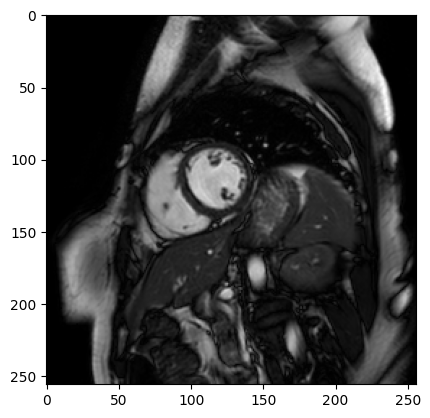

In [74]:
fig = plt.figure()
plt.imshow(torch.abs(target_image), cmap='gray')
plt.show()

In the `exp_fig_3` folder are worst-case perturbations, i.e., noise optimized to distort the prediction of the model while being as small as possible. Apply those perturbations to the data. Are those perturbations visible in image space? Is the CNN unstable or does it hallucinate?

In [75]:
def noisy_measurement(kspace: torch.Tensor, mask: torch.Tensor, noise: torch.Tensor = None, return_target = False):
    """Simulates a noisy MRI measurement.
    """
    ...
    return obs_kspace, obs_image

def deprocess_obs(x):
    """Prepare observation data for plots.
    """
    if x.device == 'cuda':
        x = x.cpu()
    if x.shape[0] == 1:
        x = x.squeeze(0)
    ...
    return x

def deprocess_rec(x):
    """Prepare reconstruction for plots.
    """
    ...
    return x

def deprocess_target(x):
    """Prepare target data for plots.
    """
    ...
    return x

In [76]:
target_kspace = torch.fft.fftshift(torch.fft.fftn(target_image))

noise1 = torch.load(os.path.join(cfg['exp_folder'], 'worst_case_perturbation.pt'))
noise2 = torch.load(os.path.join(cfg['exp_folder'], 'worst_case_perturbation_zone_1.pt'))
noise3 = torch.load(os.path.join(cfg['exp_folder'], 'worst_case_perturbation_zone_2.pt'))

obs_kspace, obs_image = noisy_measurement(target_kspace, mask)
obs_kspace1, obs_image1, target_image1 = noisy_measurement(target_kspace, mask, noise1, return_target=True)
obs_kspace2, obs_image2, target_image2 = noisy_measurement(target_kspace, mask, noise2, return_target=True)
obs_kspace3, obs_image3, target_image3 = noisy_measurement(target_kspace, mask, noise3, return_target=True)

In [77]:
with torch.no_grad():
    rec = model(obs_image, obs_kspace, mask)
    rec1 = model(obs_image1, obs_kspace1, mask)
    rec2 = model(obs_image2, obs_kspace2, mask)
    rec3 = model(obs_image3, obs_kspace3, mask)

In [78]:
target_image = deprocess_target(target_image)
target_image1 = deprocess_target(target_image1)
target_image2 = deprocess_target(target_image2)
target_image3 = deprocess_target(target_image3)

min_val, max_val = target_image.min(), target_image.max()

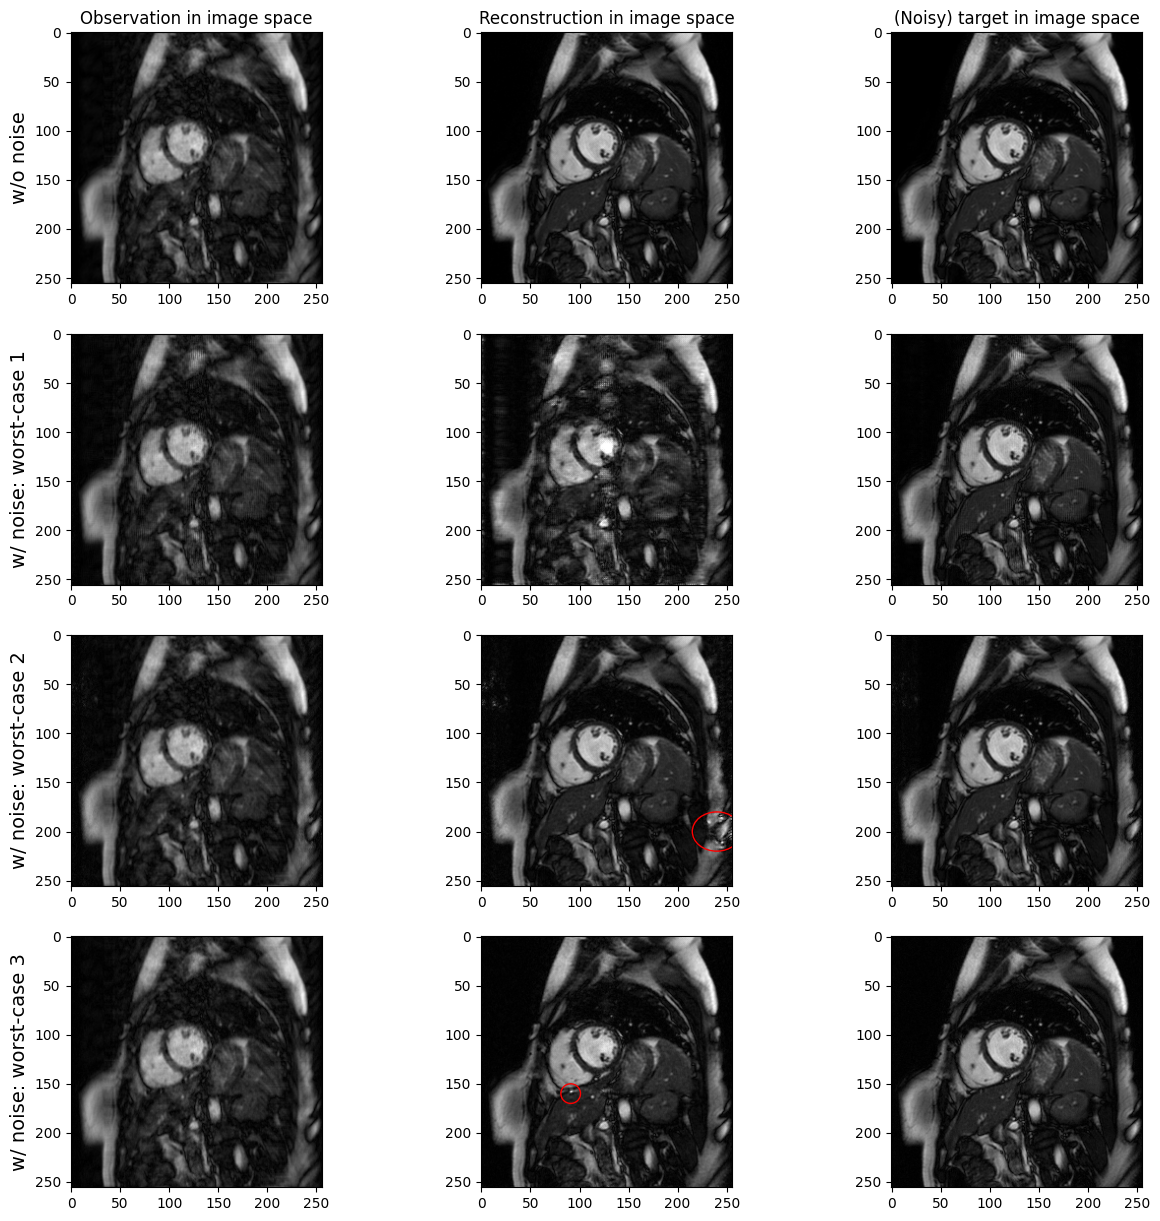

In [79]:
from matplotlib.patches import Ellipse

fig, ax = plt.subplots(4, 3, figsize=(15, 15))
ax[0, 0].imshow(deprocess_obs(obs_image), cmap='gray', vmin=min_val, vmax=max_val)
ax[0, 1].imshow(deprocess_rec(rec), cmap='gray', vmin=min_val, vmax=max_val)
ax[0, 2].imshow(target_image, cmap='gray', vmin=min_val, vmax=max_val)
ax[0, 0].set_title('Observation in image space')
ax[0, 1].set_title('Reconstruction in image space')
ax[0, 2].set_title('(Noisy) target in image space')
    
ax[1, 0].imshow(deprocess_obs(obs_image1), cmap='gray', vmin=min_val, vmax=max_val)
ax[1, 1].imshow(deprocess_rec(rec1), cmap='gray', vmin=min_val, vmax=max_val)
ax[1, 2].imshow(target_image1, cmap='gray', vmin=min_val, vmax=max_val)

ax[2, 0].imshow(deprocess_obs(obs_image2), cmap='gray', vmin=min_val, vmax=max_val)
ax[2, 1].imshow(deprocess_rec(rec2), cmap='gray', vmin=min_val, vmax=max_val)
ax[2, 2].imshow(target_image2, cmap='gray', vmin=min_val, vmax=max_val)
ellipse = Ellipse((240, 200), width=50, height=40, edgecolor='red', facecolor='none', linewidth=1)
ax[2, 1].add_patch(ellipse)

ax[3, 0].imshow(deprocess_obs(obs_image3), cmap='gray', vmin=min_val, vmax=max_val)
ax[3, 1].imshow(deprocess_rec(rec3), cmap='gray', vmin=min_val, vmax=max_val)
ax[3, 2].imshow(target_image3, cmap='gray', vmin=min_val, vmax=max_val)
ellipse = Ellipse((91, 160), width=20, height=20, edgecolor='red', facecolor='none', linewidth=1)
ax[3, 1].add_patch(ellipse)

fontsize=14
ax[0, 0].set_ylabel('w/o noise', fontsize=fontsize)
ax[1, 0].set_ylabel('w/ noise: worst-case 1', fontsize=fontsize)
ax[2, 0].set_ylabel('w/ noise: worst-case 2', fontsize=fontsize)
ax[3, 0].set_ylabel('w/ noise: worst-case 3', fontsize=fontsize)

plt.show()

Finally, write a script to compute new worst-case perturbations.